**Deep Learning Exam - June 2022**\
Epis Pietro 0001030354

After an exhaustive research about the most spread and consolidated tecniques to solve the task of image denoising and deblurring, I decided to base my solution on the approach proposed in the paper [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://arxiv.org/pdf/1608.03981v1.pdf), edited by Kai Zhang, Wangmeng Zuo, Yunjin Chen, Deyu Meng, and Lei Zhang. The ideal strategy to fulfill the requirements, according to the paper, is based on the so called *Denoising Convolutional Neural Networks* (DnCNNs), also exploiting residual learning and batch normalization to enhance the denoising performance. I also made some attempts with generative models, but the result I managed to achieve wasn't satisfactory, and anyway worse than the one reached with this final solution, despite the drawback in terms of complexity and training time of the model.
Furthermore, the adopted model allows to deal with a generic unknown noise level.

In [1]:
import tensorflow as tf 
from tensorflow.keras.layers import *
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import random
from cv2 import GaussianBlur
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [2]:
def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

The dataset that has been provided is made up by 60000 images, splitted into a training set of 50000 images and a test set of 10000. Each image is of shape 32px by 32px.

In [3]:
data = getDataset()

170508288/170498071 [==============================] - 3s 0us/step


**Network Architecture**\
First of all, the input of the network, so the noisy observation, is represented as $y = x + v$, where $v$ is the noise. Unlike what happens with discriminative denoising models, whose goal is to predict the clean image, and therefore learn a mapping $F(y) = x$, DnCNN follow a different approach. My network stands on the residual learning idea, in order to learn instead a residual mapping, $R(y) = v$. Then, the clean image will be recoverd through the inverse formula, that is $x = y - R(y)$.

The network architecture is based on three different types of composite layers:

1.   Convolutional layer and ReLU activation layer: this has been implemented through 64 filters of size 3 x 3 x 3 (indeed we're dealing with RGB images, thus having three color channels), that therefore produces 64 feature maps as output.  
2.   Convolutional layer, Batch Normalization layer and ReLU activation layer: the Convolutional layer consists in 64 filters of size 3 x 3 x 64. The Batch Normalization layer is put between the Convolutional and the Activation ones, and its goal is speed up training and enhance the denoising capability.
3.   Convolutional Layer: this is made up by 3 filters of size 3 x 3 x 64, in order to reconstruct the output (of size 32 x 32 x 3).

The actual architecture is made up by one layer of the first type, $k$ layers of the second type, and finally one layer of the third type. After some trials, $k$ has been set to 11, that allowed to get adequate results.

Finally, a Subtract layer has been added to the end of the network, in order to implement the idea at the basis of DnCNN, that has been explained previously. The Subtract layer provided by Keras accepts as argument an array of two items, and it's beavior is subtracting the second from the first one. Thus, in our case it's meant to subtract the residual estimated by the network from the input image, finally obtaining the clean image.

The network architecture can be better appreciated through the following scheme:

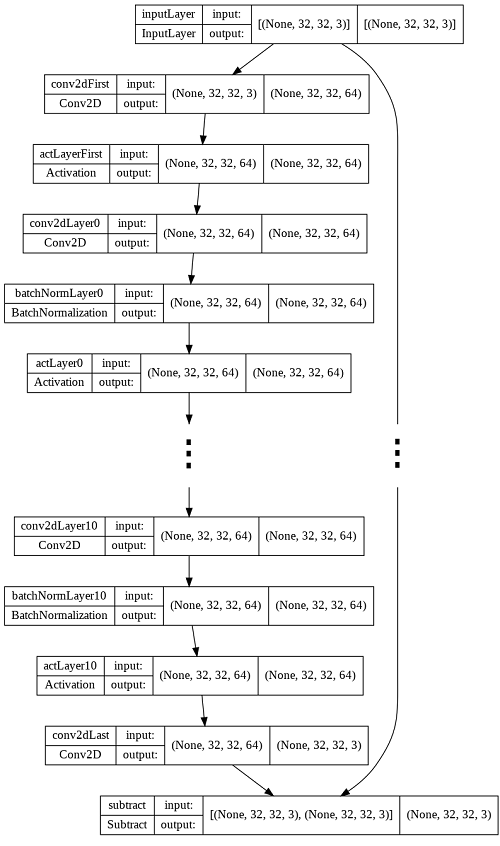

In [12]:
input = Input(shape = (32,32,3), name = "inputLayer")
x = Conv2D(64, kernel_size = (3,3), padding = "same", name = "conv2dFirst")(input)
x = Activation("relu", name = "actLayerFirst")(x)
for i in range(11):
    x = Conv2D(64, kernel_size = (3,3), padding = "same", name = "conv2dLayer" + str(i))(x)
    x = BatchNormalization(axis = -1, name = "batchNormLayer" + str(i))(x)
    x = Activation("relu", name = "actLayer" + str(i))(x)
x = Conv2D(3, kernel_size = (3,3), padding = "same", name = "conv2dLast")(x)
x = Subtract(name="subtract")([input, x])

model = tf.keras.Model(input, x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputLayer (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2dFirst (Conv2D)           (None, 32, 32, 64)   1792        ['inputLayer[0][0]']             
                                                                                                  
 actLayerFirst (Activation)     (None, 32, 32, 64)   0           ['conv2dFirst[0][0]']            
                                                                                                  
 conv2dLayer0 (Conv2D)          (None, 32, 32, 64)   36928       ['actLayerFirst[0][0]']          
                                                                                            

**Loss and Metrics**\
The measure that has been used as loss function for the training of the network is MSE (Mean Squared Error). As regards instead the metrics that have been chosen for the evaluation of the results of the model, I decided to use three different measures. Beyond the MSE, required by the exercise instructions, I found it convenient to assess also the **PSNR** (Peak Signal-to-Noise Ratio).

I decided to take care of PSNR too since this is commonly exploited as a metric to assess the quality of an image obtained from noise removal, and therefore I thought it could provide some insights about the results.\
As the acronym suggests, PSNR refers to the ratio between the maximum possible value of a signal and the strength of the noise affecting it. Higher PSNR value imply better results.\
Formally, given the clean image $x$ (groundtruth) and the blurred one $y$, PSNR is defined as:

$PSNR = 20 log_{10} (\frac{MAX_f}{\sqrt{MSE}})$

Recall that

$MSE = \frac{1}{mn} \sum_{0}^{m-1} \sum_{0}^{n-1} \lVert f(i, j) - g(i, j) \rVert^2$ 

(where $m$ and $n$ are the images dimensions)

In [14]:
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1)

model.compile(
  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
  loss = "mse",
  metrics = [tf.keras.metrics.MeanSquaredError(), PSNR]
)

**Training**\
I empirically determined, after several trials, a suitable number of epochs in order to get the best possible metrics (lowest MSE) without running into overfitting (as explained later). I found out this number being 40.

I decided to further split the dataset and create a validation set, with size equal to 1/10 of the training set, in order to better assess the presence of overfitting.

In [15]:
# data[0] is the training set, therefore data[0][0] is input and data[0][1] the
# expected output

history = model.fit(
    data[0][0], data[0][1],
    batch_size = 16,
    epochs = 40,
    validation_split = 0.1
)

Epoch 1/40
2813/2813 [==============================] - 48s 17ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - PSNR: 22.6616 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_PSNR: 24.0265
Epoch 2/40
2813/2813 [==============================] - 47s 17ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - PSNR: 24.4769 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_PSNR: 24.8343
Epoch 3/40
2813/2813 [==============================] - 47s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - PSNR: 25.0266 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_PSNR: 25.0786
Epoch 4/40
2813/2813 [==============================] - 47s 17ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - PSNR: 25.3406 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_PSNR: 25.4722
Epoch 5/40
2813/2813 [==============================] - 46s 16ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - PSNR: 25.5767 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_PSNR

**Model Evaluation**\
I made use of the *evaluate* method, provided by Keras, in order to get the metrics of the model, computed both on the training and test sets. Below are the results achieved for MSE and PSNR.

In [16]:
train_eval = model.evaluate(data[0][0], data[0][1], verbose = 0)
test_eval = model.evaluate(data[1][0], data[1][1], verbose = 0)

print("TRAINING SET")
print("MSE:\t\t", train_eval[1])
print("PSNR:\t\t", train_eval[2], "\n")
print("TEST SET")
print("MSE:\t\t", test_eval[1])
print("PSNR:\t\t", test_eval[2])

TRAINING SET
MSE:		 0.002260663080960512
PSNR:		 26.958980560302734 

TEST SET
MSE:		 0.002309175906702876
PSNR:		 26.880390167236328


**Overfitting**\
In order to assess the presence of overfitting, that may be suspected in case the results on the training set are way much better than the ones on the validation/training set, I generated two plots basing on the metrics computed at each epoch. In particular, I decided to take into consideration the MSE metric, since it is the most relevant one and it's central in this project, but I also found it interesting to plot the PSNR metric, because of its meaningfulness in this domain.

We can clearly see for both metrics that the values at each epoch for both training and validation set are pretty much the same, and basically follow the same trend. This means that the model isn't tied to the training data, it didn't adapt excessively to the fluctuations of the data, but it's able to generalize and perform well even on unseen images.

In the tuning phase of the model, I ascertained that using a noticeably higher number of epochs during training led to significant overfitting issues (for instance with 60 epochs). On the other hand, an increase in the number of epochs small enough to avoid overfitting didn't allow to get any improvement on the metrics, but just required more time for the training.

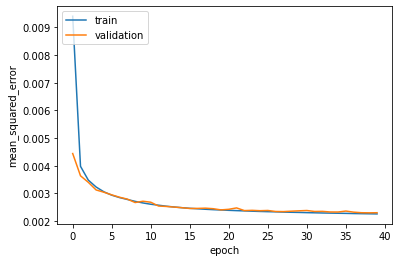

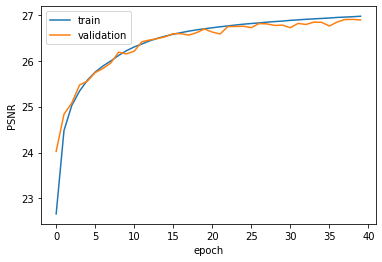

In [22]:
def plot_history(model_history, keys):
    m, val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_history(history, ["mean_squared_error", "val_mean_squared_error"])
plot_history(history, ["PSNR", "val_PSNR"])

**Demonstration of the denoising results**\
Below it's possible to appreciate the deblurring capabilities of the network, by visually inspecting the results. The first image is the original, unblurred, one (the groundtruth). The second image is the one obtained by the addition of noise (the input of the network). The last image is the result produced by the network.

By default I plot this sequence of images just for the first ten instances of the test set. Anyway, it's possible to inspect the results on different ranges of images by varying the parameters ```FROM_IMAGE``` and ```TO_IMAGE```.



Image 1


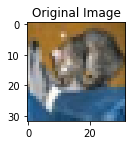

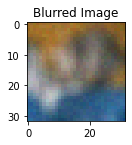

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


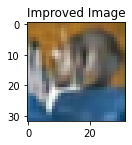

Image 2


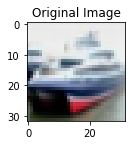

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


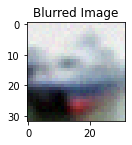

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


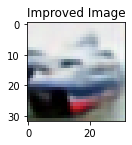

Image 3


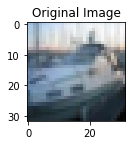

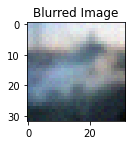

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


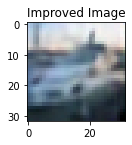

Image 4


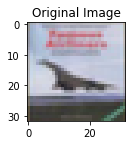

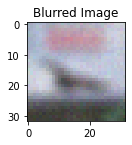

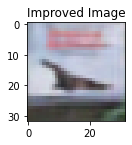

Image 5


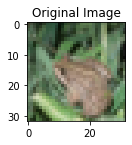

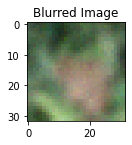

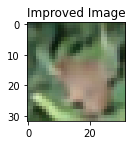

Image 6


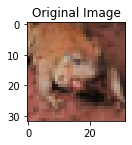

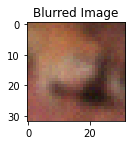

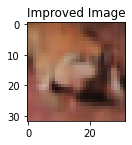

Image 7


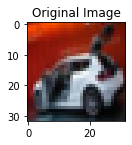

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


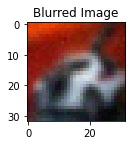

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


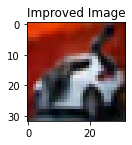

Image 8


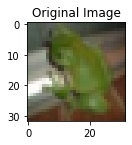

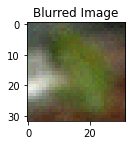

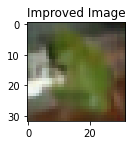

Image 9


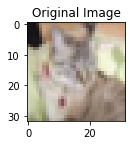

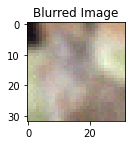

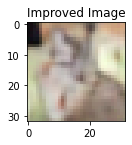

Image 10


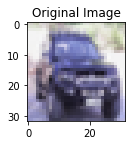

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


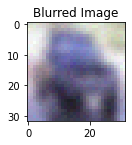

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


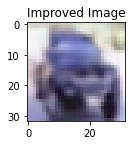

Image 11


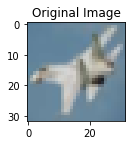

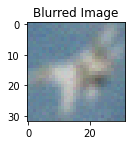

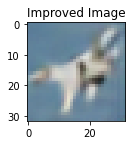

In [24]:
FROM_IMAGE = 0
TO_IMAGE = 10

for i in range(FROM_IMAGE, TO_IMAGE + 1):
  print("Image", (i + 1))
  p = model.predict(data[1][0][i:(i + 1)])
  plt.subplot(1, 3, 1)
  plt.title("Original Image")
  plt.imshow(data[1][1][i], vmin=0, vmax=1)
  plt.show()
  plt.subplot(1, 3, 2)
  plt.title("Blurred Image")
  plt.imshow(data[1][0][i], vmin=0, vmax=1)
  plt.show()
  plt.subplot(1, 3, 3)
  plt.title("Improved Image")  
  plt.imshow(p[0], vmin=0, vmax=1)
  plt.show()

In [25]:
model.save_weights("11l-40e.h5")